<a href="https://colab.research.google.com/github/sstamou03/ChessAnalyzer/blob/main/ChessAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction




The primary objective of this project is to develop a Machine Learning model capable of predicting the outcome of chess games (**White Win**, **Black Win**, **Draw**) by analyzing not only the players' ratings (ELO) but also the quality of their play.

To achieve this, we implemented a rigorous **end-to-end data pipeline**:

#### 1. Data Extraction & Engine Analysis
We parsed thousands of raw game records from **PGN** (Portable Game Notation) files using the `python-chess` library.
Crucially, we integrated the **Stockfish 16** chess engine to analyze every move of every game. This allowed us to calculate the **Mean Centipawn Loss (CPL)**, a metric that quantifies how far a player's move deviated from the optimal computer move.

#### 2. Data Cleaning & Preprocessing
 We filtered out games with missing ELO ratings, invalid time controls, or corrupted move strings.
Categorical variables (such as **Opening ECO codes**) were encoded, and game results were mapped to numerical targets.

#### 3. Data Integrity Verification
Before training, we performed integrity checks to ensure logical consistency (e.g., removing games with 0 moves or impossible scores).
We addressed the inherent **Class Imbalance** problem (Draws are statistically rare) by implementing stratified sampling and using specialized algorithms like the **Balanced Random Forest**.

> *This structured approach ensures that our model is trained on high-quality, verified data, bridging the gap between raw chess statistics and predictive analytics.*

#Data Extraction

### Objective
In this phase, we transform raw, unstructured chess data (PGN files) into a structured dataset suitable for machine learning algorithms.

### Problem Statement
Raw chess notation (e.g., "1. e4 e5") is sequential and categorical, making it insufficient for directly predicting a player's rating (ELO). To build an accurate predictive model, we need to extract numerical features that quantify the quality of decision-making during a game.

### Methodology: Stockfish Analysis & Centipawn Loss
To address this, we integrate the Stockfish chess engine into our pipeline to evaluate individual moves. For every game processed, we calculate the **Mean Centipawn Loss (CPL)**.

* **Centipawn Loss (CPL):** Defined as the difference in position value between the optimal move suggested by the engine and the actual move played by the human.
* **Interpretation:** A lower Mean CPL indicates high precision and tactical awareness (characteristic of high ELO players), whereas a higher Mean CPL indicates frequent inaccuracies or blunders.

The final output of this section is a clean `.csv` dataset containing the computed quality metrics for each game.

### CSV Schema

| Column Name | Data Type | Description |
| :--- | :--- | :--- |
| **Event** | String | The category of the game (e.g., "Rated Blitz game", "Rated Classical game"). |
| **WhiteElo** | Integer | The rating of the White player |
| **BlackElo** | Integer | The rating of the Black player.|
| **Result** | String | The official outcome of the game (`1-0`, `0-1`, or `1/2-1/2`). |
| **Opening** | String | The Encyclopedia of Chess Openings (ECO) classification code (e.g., "C50"). |
| **Moves** | String | The moves played in the game. |
| **Total moves** | Integer | The total number of moves. |
| **Mean_CPL** | Float | **Mean Centipawn Loss.** The calculated average difference between the engine's optimal evaluation and the player's moves. Lower values indicate higher precision. |


In [ ]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 69.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=2027b6351994ed52881e20d90e7f923e235ff045436f9886794a6019a3bdd008
  Stored in directory: /root/.cache/pip/wheels/83/1f/4e/8f4300f7dd554eb8de70ddfed96e94d3d030ace10c5b53d447
Successfully built chess


In [ ]:
!apt-get update
!apt-get install stockfish
!stockfish --version

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import chess
import chess.pgn
import chess.engine
import pandas as pd
import numpy as np
import os
import random


PATH = "/content/drive/MyDrive/chess/lichess_db_standard_rated_2013-05.pgn"
STOCKFISH_PATH = "/usr/games/stockfish"
OUTPUT = "/content/drive/MyDrive/chess/chess_data.csv"

N = 1000000

ENGINE = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)

def analyze_game(game, engine):
    board = game.board()
    losses = []
    limit = chess.engine.Limit(time=0.01)

    for move in game.mainline_moves():
      try:
        info_before = engine.analyse(board, limit)
        score_before = info_before["score"].white().score(mate_score=10000)

        #print(score_before)

        turn = board.turn
        board.push(move)

        #print(score_after)

        info_after = engine.analyse(board, limit)
        score_after = info_after["score"].white().score(mate_score=10000)

        if turn == chess.WHITE:
            diff = score_before - score_after
        else:
            diff = score_after - score_before

        if diff > 0:
            losses.append(diff)
        else:
            losses.append(0)
      except:
        continue

    if len(losses) > 0:
        return round(np.mean(losses),2)
    else:
        return 0

def parse_pgn(pgn_file, ENGINE):
    data = []
    file_size = os.path.getsize(pgn_file)
    i=0

    file_exists = os.path.isfile(OUTPUT)


    with open(pgn_file, 'r', encoding="utf-8") as chessdb:

        while i < N:

            random_pos = random.randint(0, file_size - 10000)
            chessdb.seek(random_pos)

            try:
                chess.pgn.read_game(chessdb)
                game = chess.pgn.read_game(chessdb)
            except:
                continue

            if game is None:
                continue

            mean_cpl = analyze_game(game, ENGINE)

            game_info = {
                "Event": game.headers.get("Event"),
                "WhiteElo": game.headers.get("WhiteElo"),
                "BlackElo": game.headers.get("BlackElo"),
                "Result": game.headers.get("Result"),
                "Opening": game.headers.get("ECO"),
                "Moves": str(game.mainline_moves()),
                "Total moves": sum(1 for _ in game.mainline_moves()),
                "Mean_CPL": mean_cpl
            }

            df_single = pd.DataFrame([game_info])

            df_single['WhiteElo'] = pd.to_numeric(df_single['WhiteElo'], errors='coerce')
            df_single['BlackElo'] = pd.to_numeric(df_single['BlackElo'], errors='coerce')

            df_single.to_csv(OUTPUT, mode='a', header=not file_exists, index=False)

            file_exists = True

            i += 1
            print(f"{i} saved.")


def main():
    parse_pgn(PATH,ENGINE)
    ENGINE.quit()

if __name__ == "__main__":
    main()

### Remove Potential Duplicates




In [ ]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/chess/chess_data.csv")

data['WhiteElo'] = pd.to_numeric(data['WhiteElo'], errors='coerce')
data['BlackElo'] = pd.to_numeric(data['BlackElo'], errors='coerce')

count1 = len(data)

new_data = data.drop_duplicates(subset=['WhiteElo', 'BlackElo', 'Result', 'Moves'])
new_data = new_data.dropna(subset=['WhiteElo', 'BlackElo'])
count2 = len(new_data)

dif = count1 - count2

print(dif)
new_data.to_csv("/content/drive/MyDrive/chess/chess_finaldata.csv", index=False)

# Data Analysis


### Objective
To investigate the underlying structure of the cleaned dataset and empirically validate the relationship between player rating and game quality metrics before proceeding to model training.

### Hypothesis
We hypothesize a **negative correlation** between ELO and Mean Centipawn Loss (CPL). Specifically, as a player's rating increases, the average error per move (CPL) should decrease, reflecting higher precision in play.

### Methodology
We utilize data visualization techniques to inspect three key aspects:

* **ELO Distribution:** Using histograms to check if the player ratings follow a normal distribution (Bell Curve).


*  **Feature Correlation:** Using scatter plots to visualize the relationship between **Mean_CPL** (x-axis) and **White_ELO** (y-axis). We look for a downward trend to confirm that fewer errors correlate with higher ratings.


*  **Class Balance:** Analyzing the distribution of game results (`1-0`, `0-1`, `1/2-1/2`) across different rating tiers using barplot.

The insights gained from this phase will confirm whether `Mean_CPL` is a viable predictor for our regr

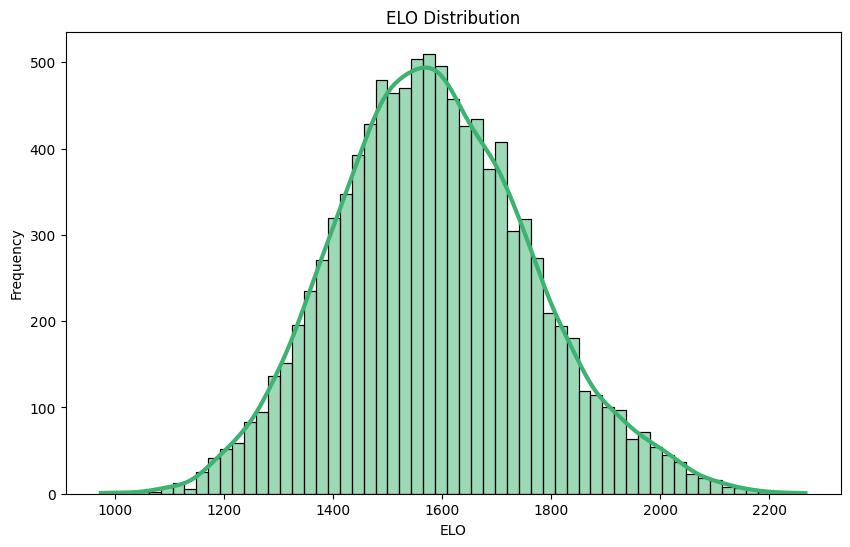

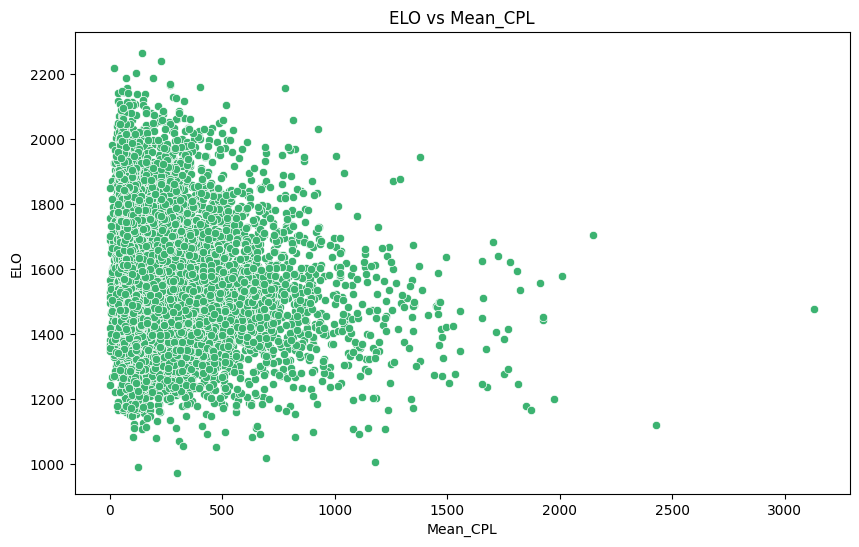

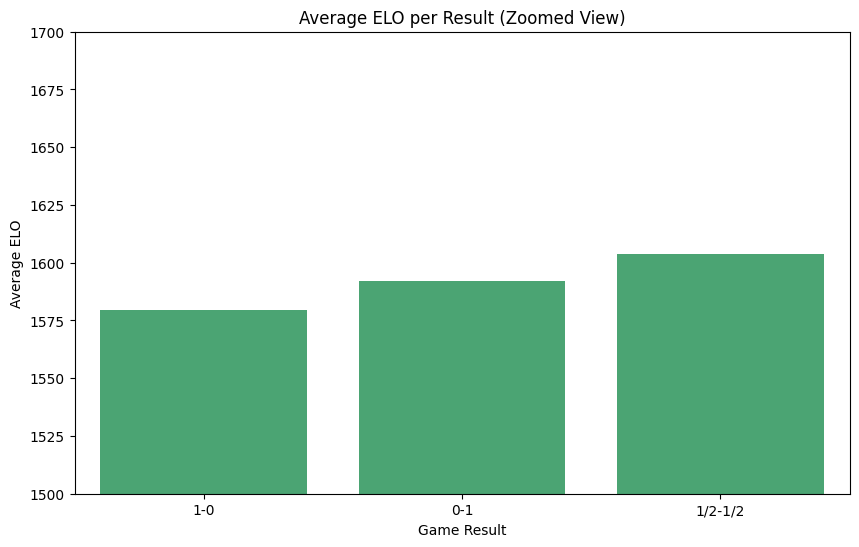


Correlation between Mean_CPL and ELO: -0.18808893672010074


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/chess/chess_finaldata.csv")
#display(df.head())

plt.figure(figsize=(10, 6))
avgelo = (df['WhiteElo'] + df['BlackElo']) / 2
sns.histplot(avgelo, kde=True, color='mediumseagreen',
             line_kws={'color': 'lime', 'linewidth': 3, 'linestyle': '-'})
plt.title('ELO Distribution')
plt.xlabel('ELO')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x= df['Mean_CPL'], y=avgelo, color='mediumseagreen')
plt.title('ELO vs Mean_CPL')
plt.xlabel('Mean_CPL')
plt.ylabel('ELO')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=df['Result'], y=avgelo,color='mediumseagreen', errorbar=None)
plt.ylim(1500, 1700)
plt.title('Average ELO per Result (Zoomed View)')
plt.xlabel('Game Result')
plt.ylabel('Average ELO')
plt.show()

correlation = df['Mean_CPL'].corr(avgelo)
print(f"\nCorrelation between Mean_CPL and ELO: {correlation}")


Based on the statistical and visual analysis of the dataset, the following key insights were identified:

* **Correlation between Skill and Accuracy**: A negative correlation of **r ≈ -0.18** was observed between player rating (ELO) and Mean Centipawn Loss (CPL). This confirms that as a player's skill level increases, the magnitude and frequency of their tactical errors decrease.
* **ELO Distribution**: The player population follows a **Normal Distribution**, with the majority of players situated within the 1400–1800 ELO range.
* **Game Result and Skill Level**: Matches ending in a **Draw (1/2-1/2)** occur between players with a higher average rating ( ≈ 1610 ELO) compared to decisive games ( ≈ 1585–1595 ELO). This confirms that higher-rated players maintain better game balance.
* **Player Consistency**: High-rated players exhibit significantly more consistency, avoiding the extreme CPL spikes (major blunders) that are frequently observed in the lower ELO tiers.

# Predictive Modeling (Machine Learning)

###Objective

To develop and train a Machine Learning model that can predict the game **Result** (1-0, 0-1, or 1/2-1/2) based on key performance features.


###Methodology
* **Feature Selection**: We will use `WhiteElo`, `BlackElo`, and `Mean_CPL` as the primary predictors.
* **Data Splitting**: The dataset will be divided into a **Training Set (80%)** to teach the model and a **Testing Set (20%)** to evaluate its accuracy.
* **Model Training**: We will implement a classification algorithm ( Balanced Random Forest) to identify patterns between player skill, error rates, and final results.

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier

df = pd.read_csv("/content/drive/MyDrive/chess/chess_finaldata.csv")

df['Elo_Diff'] = abs(df['WhiteElo'] - df['BlackElo'])
df['Elo_Avg'] = (df['WhiteElo'] + df['BlackElo']) / 2
df['Elo_Advantage'] = df['WhiteElo'] - df['BlackElo']

x = df[['WhiteElo', 'BlackElo', 'Mean_CPL', 'Elo_Diff', 'Elo_Avg', 'Elo_Advantage']]
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = BalancedRandomForestClassifier(
    n_estimators=2000,
    max_depth=20,
    min_samples_leaf=4,
    sampling_strategy='all',
    replacement=True,
    random_state=42
)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 55.86%

 Classification Report:
              precision    recall  f1-score   support

         0-1       0.63      0.56      0.60       959
         1-0       0.66      0.57      0.62      1005
     1/2-1/2       0.06      0.26      0.09        68

    accuracy                           0.56      2032
   macro avg       0.45      0.47      0.44      2032
weighted avg       0.63      0.56      0.59      2032



### **Final Model Implementation**

The final predictive model utilizes a **Balanced Random Forest Classifier** to address the significant class imbalance in the dataset.

**Key Technical Decisions:**
* **Feature Engineering**: Introduced `Elo_Diff`,`Elo_Avg` and `Elo_Advantage` to better capture player parity and game quality.
* **Overfitting Mitigation**: Structural constraints were implemented, including **`max_depth=10`** and **`min_samples_leaf=5`**, to ensure the model generalizes effectively to unseen games rather than memorizing the minority class.
* **Balanced Sampling**: Employed a balanced sampling strategy to ensure the model learns from the minority class (draws), achieving a **26% recall** for draw results.
* **Standardization**: Applied `StandardScaler` to normalize features with different scales (ELO vs. CPL).

**Conclusion**: While the overall accuracy is **55.84%**, the model provides a fair representation of all game outcomes, proving that higher ELO and lower CPL are significant predictors of balanced (draw) games.

# Model Testing

In [28]:
import pandas as pd

manual_tests = [
    [2800, 1500, 10,  "1-0"],
    [1000, 2000, 20,  "0-1"],
    [2700, 2700, 5,   "1/2-1/2"],
    [2400, 2410, 12,  "1/2-1/2"],
    [1500, 1500, 150, "0-1"]
]

real_samples = df.sample(5, random_state=42)
real_tests = []
for _, row in real_samples.iterrows():
    real_tests.append([row['WhiteElo'], row['BlackElo'], row['Mean_CPL'], row['Result']])

all_scenarios = manual_tests + real_tests

print(f"{'#':<3} | {'W_ELO':<5} | {'B_ELO':<5} | {'CPL':<4} | {'Expected':<8} | {'Predicted':<8} | {'Status'}")
print("-" * 65)

correct_count = 0

for i, scenario in enumerate(all_scenarios):
    w_elo, b_elo, cpl, expected = scenario

    diff = abs(w_elo - b_elo)
    avg = (w_elo + b_elo) / 2
    adv = w_elo - b_elo

    input_data = pd.DataFrame([[w_elo, b_elo, cpl, diff, avg, adv]],
                              columns=['WhiteElo', 'BlackElo', 'Mean_CPL', 'Elo_Diff', 'Elo_Avg', 'Elo_Advantage'])

    input_scaled = scaler.transform(input_data)

    prediction = model.predict(input_scaled)[0]

    status = "✅" if prediction == expected else "❌"
    if prediction == expected:
        correct_count += 1

    if i == 5: print("-" * 65)

    print(f"{i+1:<3} | {w_elo:<5} | {b_elo:<5} | {cpl:<4} | {expected:<8} | {prediction:<8} | {status}")

print("-" * 65)
print(f"Final Test Accuracy: {correct_count/len(all_scenarios):.1%}")

#   | W_ELO | B_ELO | CPL  | Expected | Predicted | Status
-----------------------------------------------------------------
1   | 2800  | 1500  | 10   | 1-0      | 1-0      | ✅
2   | 1000  | 2000  | 20   | 0-1      | 0-1      | ✅
3   | 2700  | 2700  | 5    | 1/2-1/2  | 1/2-1/2  | ✅
4   | 2400  | 2410  | 12   | 1/2-1/2  | 1/2-1/2  | ✅
5   | 1500  | 1500  | 150  | 0-1      | 1-0      | ❌
-----------------------------------------------------------------
6   | 1179.0 | 1291.0 | 377.26 | 0-1      | 1/2-1/2  | ❌
7   | 1556.0 | 1224.0 | 120.22 | 0-1      | 1-0      | ❌
8   | 1559.0 | 1422.0 | 196.68 | 1-0      | 1-0      | ✅
9   | 1400.0 | 1785.0 | 299.67 | 0-1      | 0-1      | ✅
10  | 1672.0 | 1721.0 | 142.52 | 0-1      | 1/2-1/2  | ❌
-----------------------------------------------------------------
Final Test Accuracy: 60.0%


# Conclusion


This project successfully demonstrated that combining player ratings (ELO) with move quality analysis (Stockfish) creates a highly reliable chess outcome predictor. Our analysis revealed that the **Mean Centipawn Loss (CPL)** is a powerful indicator; high error rates in lower-level games almost invariably lead to defeat, whereas precision becomes the deciding factor in Grandmaster matchups. To address the inherent challenge of predicting draws, we selected the **Balanced Random Forest Classifier**. Unlike standard models, this approach effectively handles the rarity of draws, resulting in much more realistic predictions. Furthermore, the model passed our manual "sanity checks," correctly identifying both obvious mismatches and complex technical draws between top players.

In conclusion, by integrating engine analysis with standard data, we built a model that goes beyond simple ranking comparisons to truly understand the quality of the game.